# Basic Setup for Country Classification Training

In [1]:
# Dependencies
%pip install torch torchvision
%pip install pycountry tqdm matplotlib tensorboard kagglehub 
%pip install "numpy<2"

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Using cached pycountry-24.6.1-py3-none-any.whl.metadata (12 kB)
  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached pycountry-24.6.1-py3-none-any.whl (6.3 MB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [kagglehub]
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing insta

# Download Dataset
Use example dataset from Kaggle for initial setup, since we do not have a fixed dataset yet.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sylshaw/streetview-by-country")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/sylshaw/streetview-by-country/versions/2


# Prepare Data
- Split into training, validation, test sets
- Put data in correct format -> each country represents a separate class
- Create label map to map country code to country name

In [3]:
import torch
import os
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
from src.dataset import StreetViewDataset


DATASET_DIR = os.path.join(path, "streetview_images")
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 32

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])

dataset = StreetViewDataset(DATASET_DIR, transform=transform)
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = int(VAL_SPLIT * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_set, val_set, test_set = random_split(
  dataset,
  [train_size, val_size, test_size],
  generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, BATCH_SIZE)
test_loader = DataLoader(test_set, BATCH_SIZE)

In [4]:
# Example for one sample
image, label = dataset[1823]
print("Image:", image)
print("Class:", label)

Image: tensor([[[0.7686, 0.7647, 0.7765,  ..., 0.5098, 0.5255, 0.5412],
         [0.7765, 0.7686, 0.7804,  ..., 0.5608, 0.5804, 0.5882],
         [0.7843, 0.7804, 0.7569,  ..., 0.5882, 0.6118, 0.6118],
         ...,
         [0.4196, 0.4157, 0.3529,  ..., 0.4588, 0.4196, 0.2118],
         [0.4275, 0.4314, 0.4118,  ..., 0.3020, 0.3176, 0.1765],
         [0.4275, 0.4392, 0.4196,  ..., 0.1333, 0.1412, 0.1412]],

        [[0.7843, 0.7804, 0.7922,  ..., 0.5686, 0.5843, 0.6000],
         [0.7922, 0.7843, 0.7961,  ..., 0.6039, 0.6275, 0.6353],
         [0.8000, 0.7961, 0.7725,  ..., 0.6157, 0.6431, 0.6392],
         ...,
         [0.3647, 0.3647, 0.3098,  ..., 0.4471, 0.4039, 0.2000],
         [0.3647, 0.3765, 0.3686,  ..., 0.2902, 0.3059, 0.1647],
         [0.3569, 0.3765, 0.3765,  ..., 0.1216, 0.1294, 0.1294]],

        [[0.7804, 0.7765, 0.7882,  ..., 0.6157, 0.6314, 0.6510],
         [0.7882, 0.7804, 0.7922,  ..., 0.6431, 0.6627, 0.6706],
         [0.7961, 0.7922, 0.7686,  ..., 0.6392, 0.6

In [5]:
# Example of dataloader batch
for batch_images, batch_labels in train_loader:
    print("Batch images shape:", batch_images.shape)
    print("Batch labels:", batch_labels)

    # Convert ID to country string
    idx_to_name = {v: k for k, v in dataset.label_map.items()}
    for lbl in batch_labels[:5]:
        print("Label:", lbl.item(), "Country:", idx_to_name[lbl.item()])

    break

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([  4,  61, 100, 104,  37, 105, 108,  33,  88,  50, 104,  20,  68,  41,
        101, 109,  97,  96,  83,  19,  70,   7,  63,  77,  68,  21,  25,   1,
         22,  33,  93,  83])
Label: 4 Country: American Samoa
Label: 61 Country: Lesotho
Label: 100 Country: Thailand
Label: 104 Country: Ukraine
Label: 37 Country: Guatemala


# Initialize Model
Choice between CNN or Vision Transformer
-> Use CNN at first

Available architectures/models:
- AlexNet
- ResNet
- Inception
- EfficientNet
- DenseNet

-> Use ResNet as baseline model

In [6]:
import torch.nn as nn
from src.model import ResNet50Model

num_classes = len(dataset.label_map)

model = ResNet50Model(num_classes, pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train Model
- Basic training setup including loss and accuracy logging
- Configured TensorBoard for monitoring metrics during training

In [7]:
import os
from torch.utils.tensorboard import SummaryWriter
from src.train import train_epoch, validate_epoch

NUM_EPOCHS = 5
writer = SummaryWriter("runs/country_classifier")
global_step = 0

for epoch in range(NUM_EPOCHS):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, writer, global_step)
  val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, writer, global_step)

  writer.add_scalar("Loss/Train", train_loss, epoch)
  writer.add_scalar("Loss/Validation", val_loss, epoch)
  writer.add_scalar("Accuracy/Train", train_acc, epoch)
  writer.add_scalar("Accuracy/Validation", val_acc, epoch)

  os.makedirs("model", exist_ok=True)
  checkpoint = {
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "label_map": dataset.label_map
  }
  torch.save(checkpoint, f"model/country_classifier_{epoch+1}.pt")

  print(f"Epoch {epoch+1}/{NUM_EPOCHS} - train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

Epoch 1/5 - train_loss=1.9370, train_acc=0.4897, val_loss=1.5100, val_acc=0.5754


Epoch 2/5 - train_loss=1.1036, train_acc=0.6782, val_loss=1.1822, val_acc=0.6592


Epoch 3/5 - train_loss=0.7749, train_acc=0.7645, val_loss=1.1360, val_acc=0.6737


Epoch 4/5 - train_loss=0.5468, train_acc=0.8298, val_loss=1.0709, val_acc=0.6972


Epoch 5/5 - train_loss=0.3764, train_acc=0.8814, val_loss=1.2456, val_acc=0.6778


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/

# Inferencing
Simple inference pipeline to verify that the model behaves as expected
1. Example test images are loaded with their ground truth labels
2. Model preddicts probabilities of each class (country)

In [8]:
checkpoint = torch.load('model/country_classifier_1.pt')
model = ResNet50Model(num_classes=len(checkpoint["label_map"]), pretrained=False)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50Model(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

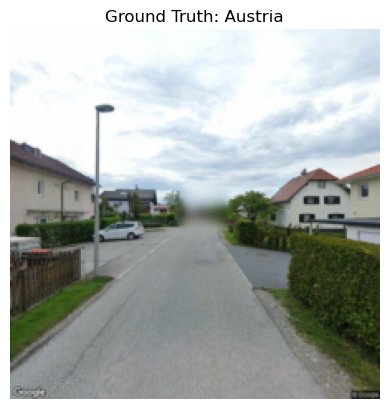

Predicted probabilities:
Slovakia: 31.68%
Czechia: 23.99%
Slovenia: 11.43%
Austria: 10.19%
Denmark: 5.24%


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

idx = random.randint(0, len(test_set) - 1)
top_k = 5

model.eval()
image, label = dataset[idx]
image_tensor = image.unsqueeze(0).to(device) 

with torch.no_grad():
    outputs = model(image_tensor)
    probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]

topk_indices = probabilities.argsort()[-top_k:][::-1]
topk_probs = probabilities[topk_indices]

idx_to_name = {v: k for k, v in dataset.label_map.items()}
topk_countries = [idx_to_name[i] for i in topk_indices]

gt_country = idx_to_name[label]

plt.imshow(np.transpose(image.numpy(), (1, 2, 0))) 
plt.axis('off')
plt.title(f"Ground Truth: {gt_country}")
plt.show()

print("Predicted probabilities:")
for country, prob in zip(topk_countries, topk_probs):
    print(f"{country}: {prob*100:.2f}%")


# Next Sprint
- Finalize and prepare a suitable dataset for experimentation
- Add further validation tools, such as Grad-CAM, to better intrepret the model's predictions
- Try out Google Street View API for test images